In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import scipy

In [2]:
def tau_effcal(dis_dens, bs, v0, Qs, Temp, ts, p, q, shear_strain_rate):
    #sub-function to calculate effective stress
    k_b = 1.381e-23
    thermal_var = -Temp*k_b/Qs
    ln_term = np.log(shear_strain_rate/(dis_dens*bs*v0))
    tau_eff = abs(ts *(1-(thermal_var*ln_term)**(1/p))**1/q)
    return tau_eff

def fake_dislotwin(dis_dens, 
                   b_s, 
                   v_0, 
                   Q_s, 
                   T, 
                   tau_sol, 
                   p_s, q_s, 
                   e_s_1,
                   MFP,
                   Bulk_modulus,
                   h,
                   strain,
                   taylor_factor=3.06,
                   time_incs= 0.0001):
    #Sub function that calculates the shear stress for each given shear strain in a strain vector
    #effective stress is dependent on dislocation density, which increases over time depending on shear stress
    #Euler forward propagation is used. Variable names correspond to DAMASK paper
    shear_stress = 0
    strain /= taylor_factor
    #print(type(strain),strain)
    increments = int((strain/0.1)/time_incs)#int((strain/e_s_1)/time_incs)
    gamma_dot = e_s_1/taylor_factor
    rho = dis_dens
    for i in range(increments):
        tau_eff = tau_effcal(rho, b_s, v_0, Q_s, T, tau_sol, p_s, q_s, gamma_dot)
        shear_stress = tau_eff + Bulk_modulus * b_s * (rho * h)**0.5
        d_hat = Bulk_modulus*3*b_s/(16*3.14159*shear_stress)
        #print(gamma_dot, b_s,MFP)
        rho += time_incs*((gamma_dot/(b_s*MFP)) + (2*d_hat*rho*gamma_dot/b_s))
    return shear_stress*taylor_factor

def dislomodel(theta, strain_vector):
    #This function is for ease of use of the dislotwin function. variables are as per the DAMASK paper
    #except dis_dens is the dislocation density inital value, e_s_1 is the strain rate, and MFP is the
    #Dislocation mean free path that actually encapsulates other variables
    dis_dens, b_s, v_0, Q_s, T, tau_sol, p_s, q_s, e_s_1, MFP,h, Bulk_modulus = theta
    stress_vector = []
    for strain in strain_vector:
        stress_vector.append(fake_dislotwin(dis_dens, 
                   b_s, 
                   v_0, 
                   Q_s,  
                   T, 
                   tau_sol, 
                   p_s, q_s, 
                   e_s_1,
                   MFP,
                   Bulk_modulus,
                   h,
                   strain))
        #print(stress_vector)
        #print(strain_vector)
        #print(theta)
    return stress_vector

In [3]:
#Function that generates random values of input variables
def random_theta():
    dis_dens = 10**(np.random.uniform(low=6, high=8))
    b_s = 10**(-np.random.uniform(low=7.5, high=8.5))
    v_0 = 10**(np.random.uniform(low=0, high=2))
    Q_s = 10**(-np.random.uniform(low=18, high=20))
    T = 1323
    tau_sol = 10**(np.random.uniform(low=5, high=8))
    p_s = np.random.uniform(low=0.8, high=1)
    q_s = np.random.uniform(low=1.2, high=4)
    e_s_1 =0.1
    MFP = 10**(-np.random.uniform(low=3, high=5))
    h = 1
    Bulk_modulus = 45e9
    rand_theta = [dis_dens, b_s, v_0, Q_s, T, tau_sol, p_s, q_s, e_s_1, MFP, h, Bulk_modulus]
    return rand_theta,{'dis_dens':dis_dens, 
                       'b_s':b_s, 
                       'v_0':v_0, 
                       'Q_s':Q_s, 
                       'T':T, 
                       'tau_sol':tau_sol, 
                       'p_s':p_s,
                       'q_s':q_s, 
                       'e_s_1':e_s_1, 
                       'MFP':MFP, 
                       'h':h,
                       'Bulk_modulus':Bulk_modulus}

In [5]:
#data and noise for likelihood function
data = np.loadtxt('/Users/user/Documents/Monte_carlo/Dislotwin_mini_sim/luo_flat/e01s-1flat.csv',delimiter=',')
noise = 4e6

def likelihood(data_stress, model_stress, noise):
    return np.exp(-sum(((data_stress-model_stress)/(2*noise*len(data_stress)))**2))

reassurance iteraterion: 0
reassurance iteraterion: 1
reassurance iteraterion: 2
reassurance iteraterion: 3
reassurance iteraterion: 4
reassurance iteraterion: 5


/var/folders/pp/3cvdv_lx45x0qmbdmgb67cl40000gp/T/ipykernel_14671/873222360.py:6: RuntimeWarning: invalid value encountered in double_scalars
  tau_eff = abs(ts *(1-(thermal_var*ln_term)**(1/p))**1/q)


reassurance iteraterion: 6
reassurance iteraterion: 7
reassurance iteraterion: 8
reassurance iteraterion: 9
reassurance iteraterion: 10
reassurance iteraterion: 11
reassurance iteraterion: 12
reassurance iteraterion: 13
reassurance iteraterion: 14
reassurance iteraterion: 15
reassurance iteraterion: 16
reassurance iteraterion: 17
reassurance iteraterion: 18
reassurance iteraterion: 19
reassurance iteraterion: 20
reassurance iteraterion: 21
reassurance iteraterion: 22
reassurance iteraterion: 23
reassurance iteraterion: 24
reassurance iteraterion: 25
reassurance iteraterion: 26
reassurance iteraterion: 27
reassurance iteraterion: 28
reassurance iteraterion: 29
reassurance iteraterion: 30
reassurance iteraterion: 31
reassurance iteraterion: 32
reassurance iteraterion: 33
reassurance iteraterion: 34
reassurance iteraterion: 35
reassurance iteraterion: 36
reassurance iteraterion: 37
reassurance iteraterion: 38
reassurance iteraterion: 39
reassurance iteraterion: 40
reassurance iteraterion:

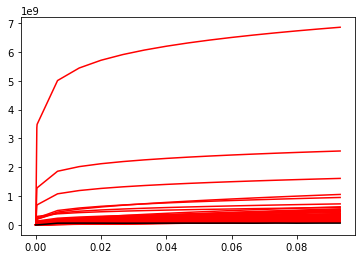

In [6]:
#generate random flow curves just to check model is behaving as expected
for i in range(100):
    plt.figure(2)
    case_theta, t = random_theta()
    plt.plot(data[:,0], dislomodel(case_theta, data[:,0]), color='r')
    print('reassurance iteraterion:',i)
plt.plot(data[:,0], data[:,1], color='k')
# plt.ylim([0,1e10])

In [7]:
#generate no_tests numer of flow curves and calculate likelihoods.
values_tuple = ()
no_tests = 700
ct, theta_dict = random_theta()
values_array = np.zeros([no_tests,len(ct)])
likelihood_weights = np.ones(no_tests) #likelihoods to be used as weights for each value
for i in range(no_tests):
    ct, theta_dict = random_theta()
    modelstress = dislomodel(ct, data[:,0])
    like = likelihood(data[:,1], modelstress, noise)
    if np.isnan(like):
        like = 0
    values_tuple = values_tuple + ((like, theta_dict),)
    values_array[i,:len(ct)] = ct[:]
    likelihood_weights[i] = like
    
#theta contains some constants. Remove constants from array so that covarience matrix can be calculated
values_array =np.delete(values_array,11,1)
values_array=np.delete(values_array,10,1)
values_array=np.delete(values_array,8,1)
values_array=np.delete(values_array,4, 1)
values_array=np.transpose(values_array)
np.shape(values_array)
#     if like > 0.01:
#         print(theta_dict, like)

/var/folders/pp/3cvdv_lx45x0qmbdmgb67cl40000gp/T/ipykernel_14671/873222360.py:6: RuntimeWarning: invalid value encountered in double_scalars
  tau_eff = abs(ts *(1-(thermal_var*ln_term)**(1/p))**1/q)


(8, 700)

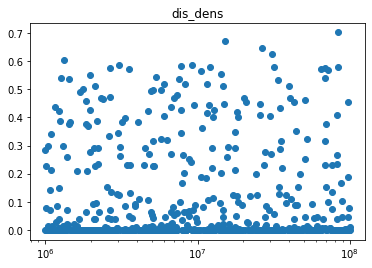

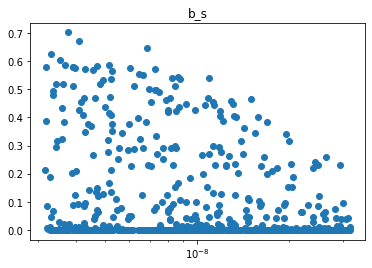

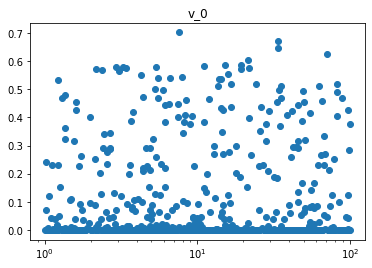

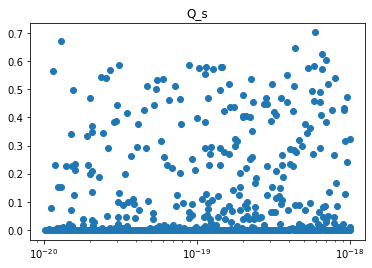

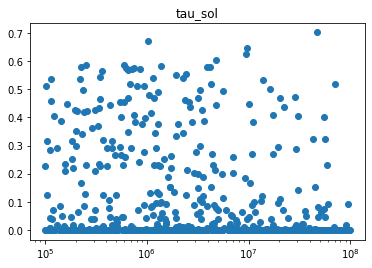

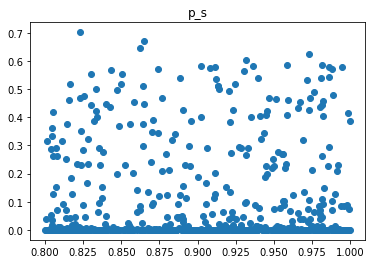

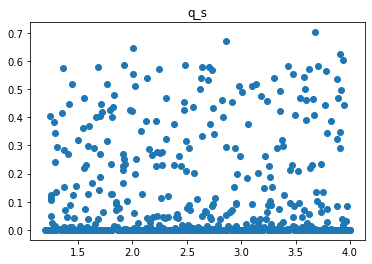

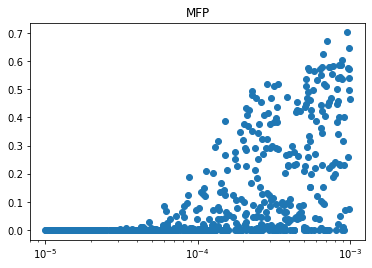

In [16]:
#Look at general shape of likelihood for individual values
keys = ['dis_dens',
                       'b_s',
                       'v_0',
                       'Q_s',
                       'tau_sol', 
                       'p_s',
                       'q_s', 
                       'MFP']
plt.figure(3)
plt.title(keys[0])
plt.xscale('log')
plt.scatter(values_array[0,:], likelihood_weights)
plt.figure(4)
plt.title(keys[1])
plt.xscale('log')
plt.scatter(values_array[1,:], likelihood_weights)
plt.figure(5)
plt.title(keys[2])
plt.xscale('log')
plt.scatter(values_array[2,:], likelihood_weights)
plt.figure(6)
plt.title(keys[3])
plt.xscale('log')
plt.scatter(values_array[3,:], likelihood_weights)
plt.figure(7)
plt.title(keys[4])
plt.xscale('log')
plt.scatter(values_array[4,:], likelihood_weights)
plt.figure(8)
plt.title(keys[5])
plt.xscale('linear')
plt.scatter(values_array[5,:], likelihood_weights)
plt.figure(9)
plt.title(keys[6])
plt.xscale('linear')
plt.scatter(values_array[6,:], likelihood_weights)
plt.figure(10)
plt.title(keys[7])
plt.xscale('log')
plt.scatter(values_array[7,:], likelihood_weights)

In [18]:
#KDE estimation- not clear on advantages of different bandwith methods but theta values
kde = scipy.stats.gaussian_kde(values_array,  weights=likelihood_weights)
#find top 90th percentile of KDE values as boolean array
top_percentile = np.percentile(kde(values_array),90) < kde(values_array)

In [20]:
for i in range(len(keys)):
    max_val = max(values_array[i,top_percentile])
    min_val = min(values_array[i,top_percentile])
    print(keys[i], 'for high likelihood values is between min:', min_val, 'and max:', max_val)

dis_dens for high likelihood values is between min: 1149109.1187882328 and max: 83348179.14221041
b_s for high likelihood values is between min: 3.198397934349601e-09 and max: 1.585076822407813e-08
v_0 for high likelihood values is between min: 1.1184029571101364 and max: 82.33172557569192
Q_s for high likelihood values is between min: 1.149846553805684e-20 and max: 6.998735764864067e-19
tau_sol for high likelihood values is between min: 101557.45893628518 and max: 47580325.76440728
p_s for high likelihood values is between min: 0.8052104997438828 and max: 0.9880224331879192
q_s for high likelihood values is between min: 1.5997743567218403 and max: 3.9367827316285045
MFP for high likelihood values is between min: 6.28465930835748e-05 and max: 0.0009919118849039733
